In [1]:
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Importing the dependencies
import cv2
import random
import os
import numpy as np
from matplotlib import pyplot as plt


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
#Importing TF modules
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [6]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [17]:
folder_path = '/content/drive/MyDrive/data/data/anchor'

# List the contents of the folder
contents = os.listdir(folder_path)
count = 0
for item in contents:
    count += 1
print(count)

320


In [7]:
!unzip data.zip -d/content/drive/MyDrive/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data/data/negative/Manijeh_Hekmat_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Gehring_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Jesus_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Llorente_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Pellegrini_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Poggiali_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Poggiali_0002.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuel_Rosendo_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Manuela_Montebrun_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Mara_Georges_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/Marat_Safin_0001.jpg  
  inflating: /content/drive/MyDrive/data/data/negative/M

In [13]:
#Set up Paths
POS_path = os.path.join('data','data')
NEG_path = os.path.join('data','data')
ANC_path = os.path.join('data','data')

In [19]:
anchor = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data/anchor/*.jpg').take(300)
positive = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data/positive/*.jpg').take(300)
negative = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data/negative/*.jpg').take(300)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    #Resizing the image to 100x100x3
    img = tf.image.resize(img,(100,100))
    #Scaling the image to be between 0 and 1.0
    img = img/255.0
    #Returning the image :)
    return img

In [22]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [23]:
iterator_labs  = class_labels.as_numpy_iterator()

In [24]:
iterator_labs.next()

0.0

In [25]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [26]:
samples = data.as_numpy_iterator()

In [27]:
samples.next()

(b'/content/drive/MyDrive/data/data/anchor/5cb7b4e0-4d83-11ef-a927-fc017c6f03cc.jpg',
 b'/content/drive/MyDrive/data/data/positive/d0831c37-4d83-11ef-af35-fc017c6f03cc.jpg',
 1.0)

In [28]:
exampple = samples.next()

In [29]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [30]:
res = preprocess_twin(*exampple)


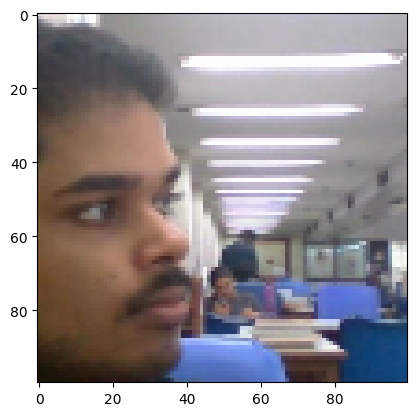

In [31]:
plt.imshow(res[0])

In [33]:
#Build Data Loader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

TypeError: in user code:

    File "<ipython-input-29-f18d4e18a455>", line 2, in preprocess_twin  *
        return (preprocess(input_img),preprocess(validation_img),label)
    File "<ipython-input-21-6ef40e348310>", line 2, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [34]:
#Training Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [35]:
train_samples = train_data.as_numpy_iterator()

In [36]:
train_sample = train_samples.next()

In [37]:
round(len(data)*.7)

310

In [38]:
#Testing data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [39]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

In [44]:
input_image  = Input(name = 'input_img',shape = (100,100,3))
validation_image  =Input(name = 'validation_img',shape = (100,100,3))

In [45]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
siamese_layer(inp_embedding,val_embedding)


<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [48]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt =  tf.keras.optimizers.Adam(1e-4)

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt,siamese_model = siamese_model)

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [57]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch%10==0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [58]:
train(train_data,50)


 Epoch 150
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
20/20 [==============================] - 32s 2s/step

 Epoch 250
20/20 [==============================] - 30s 2s/step

 Epoch 350
20/20 [==============================] - 30s 1s/step

 Epoch 450
20/20 [==============================] - 30s 2s/step

 Epoch 550
20/20 [==============================] - 30s 1s/step

 Epoch 650
20/20 [==============================] - 30s 1s/step

 Epoch 750
20/20 [==============================] - 30s 1s/step

 Epoch 850
20/20 [==============================] - 30s 1s/step

 Epoch 950
20/20 [==============================] - 29s 1s/step

 Epoch 1050
20/20 [==============================] - 29s 1s/step

 Epoch 1150
20/20 [==============================] - 30s 1s/step

 Epoch 1250
20/20 [==============================] - 29s 1s/step

 Epoch 1350
20/20 [==============================] - 30s 1s/st

In [59]:
from tensorflow.keras.metrics import Precision,Recall

In [60]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [61]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 395ms/step


In [62]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [63]:
y_true

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

In [64]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [65]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [66]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 164ms/step
1.0 1.0


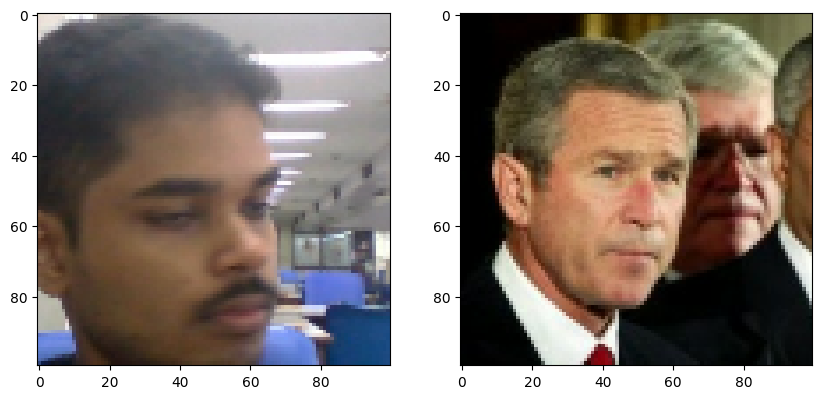

In [67]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [68]:
siamese_model.save('siamesemodelv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
L1Dist

__main__.L1Dist

In [70]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [71]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 272ms/step


array([[1.1276690e-09],
       [8.1717602e-09],
       [1.8886344e-09],
       [1.1166618e-08],
       [9.9999493e-01]], dtype=float32)

In [72]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [74]:
application_data/verification_images

NameError: name 'application_data' is not defined

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):

    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results